The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


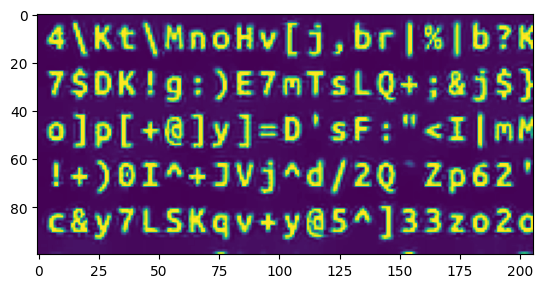

In [20]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import json
import text_extract as text

JSON_PATH = "./settings.json"

with open(JSON_PATH) as f:
    settings = json.load(f)

file_setting = settings["file"]
gray_img = text.data.read_image(**file_setting)

rotate_img = text.extract.set_textbox_horizontally(gray_img[400:700, :400], settings)
textbox_img = text.extract.extract_textbox(rotate_img, settings)
enhanced_textbox = text.extract.enhance_textbox(textbox_img, settings)

plt.imshow(enhanced_textbox)
plt.show()

In [ ]:
# 수직 방향의 픽셀들을 합친 값
hori_sum = np.sum(contrast_img, axis=1) / contrast.shape[0]
hori_thresh = np.min(hori_sum) + 15
hori_points = hori_sum < hori_thresh

check_start = None
check_end = None
hori_line_point = []



for idx, point in enumerate(hori_points):
    try:
        if point:
            if check_start == None:
                check_start = idx
            if hori_points[idx + 1] == False:
                check_end = idx + 1
                min_val = np.argmin(hori_sum[check_start:check_end]) + check_start
                hori_line_point.append(min_val)
                check_start = None
                check_end = None
    except IndexError:
        check_end = idx
        min_val = np.argmin(hori_sum[check_start:check_end]) + check_start
        hori_line_point.append(min_val)
        check_start = None
        check_end = None

vert_sum = np.sum(contrast_img, axis=0) / contrast.shape[1]

vert_thresh = np.min(vert_sum) + 15
vert_points = vert_sum < vert_thresh

check_start = None
check_end = None
vert_line_point = []


for idx, point in enumerate(vert_points):
    if point:
        if check_start == None:
            check_start = idx

        if idx == len(vert_points) - 1:
            check_end = idx
            min_val = np.argmin(vert_sum[check_start:check_end]) + check_start
            vert_line_point.append(min_val)
            check_start = None
            check_end = None
        elif not vert_points[idx + 1]:
            check_end = idx + 1
            min_val = np.argmin(vert_sum[check_start:check_end]) + check_start
            vert_line_point.append(min_val)
            check_start = None
            check_end = None

  
# (h, w) = dst.shape
# m = cv2.getRotationMatrix2D((h/2, w/2), 10, 1.0)
# rotate = cv2.warpAffine(dst, m, (h, w))

print(hori_line_point)
print(vert_line_point)

plt.imshow(contrast_img)
plt.title("Contrast")

# for point in hori_line_point:
#     plt.plot([0, contrast.shape[1] - 1], [point, point], color="red", linewidth=1)

# for point in vert_line_point:
#     plt.plot([point, point], [0, contrast.shape[0] - 1], color="red", linewidth=1)

plt.show()

# '`,.~-08BOD5S$

# 헷갈릴 글자 대상들
# 0 Γ
# 8 Δ
# 5 Σ
# $ -> § or 직접 폰트 수정
#  (공백) Ч
# ` §

# 절대로 헷갈리지 않을 만한 문자들
# 그리스어
# Γ Δ Ξ Σ